Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
!pip install Augmentor

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

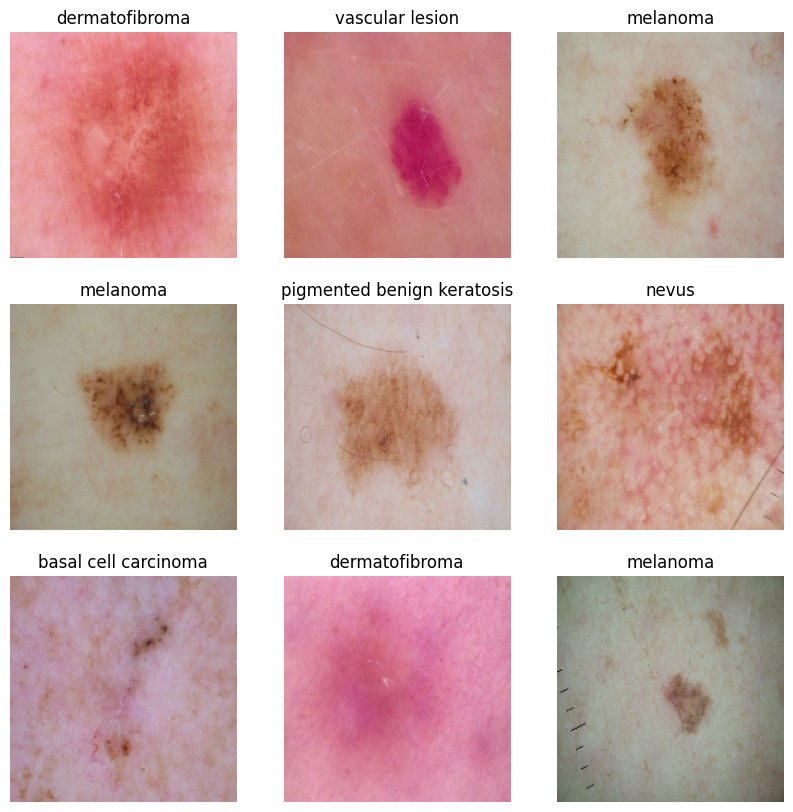

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
input_shape = (180,180,3)

# Create the CNN model
"""
model = models.Sequential([
    normalization_layer,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_height, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
"""

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 87, 87, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 87, 87, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 431s 498ms/step - loss: nan - accuracy: 0.0540 - val_loss: nan - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 3s 40ms/step - loss: nan - accuracy: 0.0509 - val_loss: nan - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 3s 39ms/step - loss: nan - accuracy: 0.0509 - val_loss: nan - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 3s 41ms/step - loss: nan - accuracy: 0.0509 - val_loss: nan - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 3s 40ms/step - loss: nan - accuracy: 0.0509 - val_loss: nan - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 3s 40ms/step - loss: nan - accuracy: 0.0509 - val_loss: nan - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 3s 40ms/step - loss: nan - accuracy: 0.0509 - val_loss: nan - val_accuracy: 0.1356
Epoch 8/20
70/70 [==============================] - 

### Visualizing training results

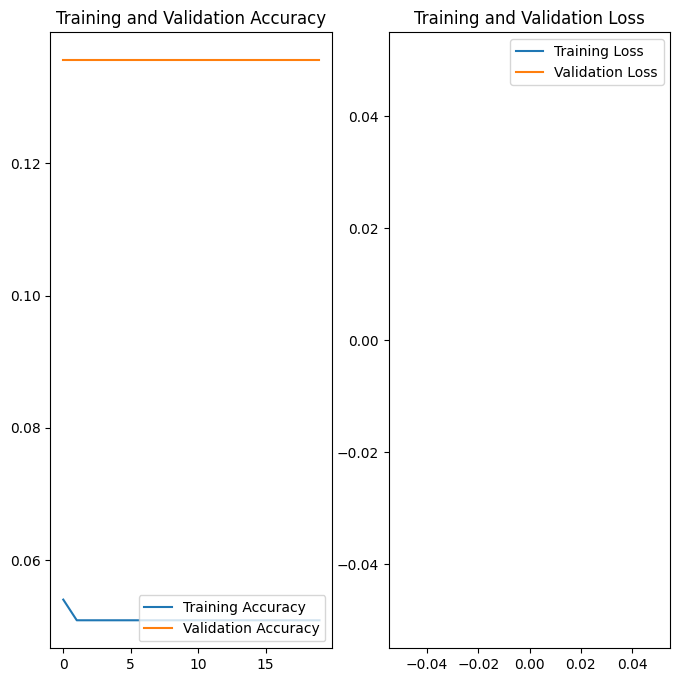

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

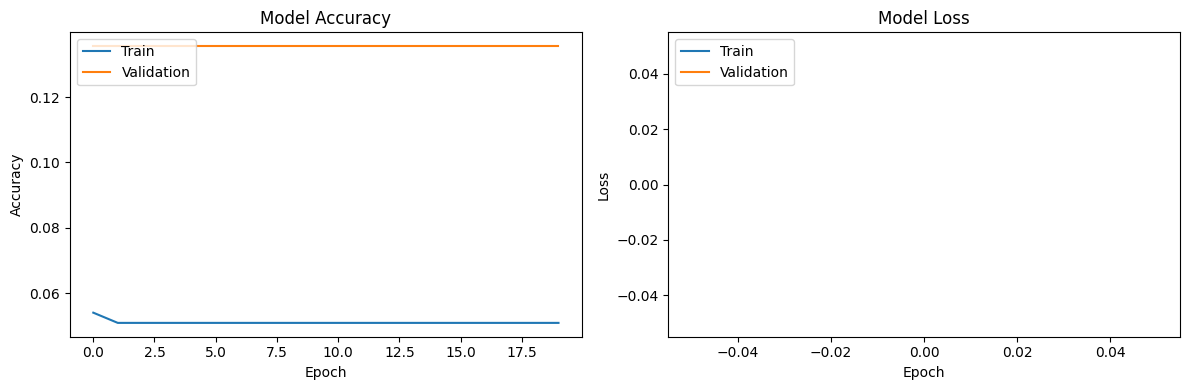

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# Data Augmentation Layer
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

# Normalize pixel values between 0 and 1
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Create the augmented training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Apply the normalization layer to both the training and validation datasets
normalized_train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_valid_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

num_classes = 9

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Create the CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [ ]:
## Your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 20, 20, 128)      

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_valid_ds,
    epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 19s 235ms/step - loss: 1.8921 - accuracy: 0.3015 - val_loss: 2.3572 - val_accuracy: 0.3051
Epoch 2/20
70/70 [==============================] - 16s 231ms/step - loss: 1.5547 - accuracy: 0.4547 - val_loss: 2.0561 - val_accuracy: 0.3729
Epoch 3/20
70/70 [==============================] - 16s 233ms/step - loss: 1.4555 - accuracy: 0.4958 - val_loss: 2.3410 - val_accuracy: 0.4237
Epoch 4/20
70/70 [==============================] - 16s 233ms/step - loss: 1.4459 - accuracy: 0.4908 - val_loss: 2.6841 - val_accuracy: 0.3390
Epoch 5/20
70/70 [==============================] - 16s 231ms/step - loss: 1.3535 - accuracy: 0.5185 - val_loss: 2.0071 - val_accuracy: 0.3644
Epoch 6/20
70/70 [==============================] - 16s 230ms/step - loss: 1.3432 - accuracy: 0.5221 - val_loss: 2.1724 - val_accuracy: 0.3644
Epoch 7/20
70/70 [==============================] - 16s 233ms/step - loss: 1.3258 - accuracy: 0.5346 - val_loss: 2.1971 - val_accuracy: 0.3898

### Visualizing the results

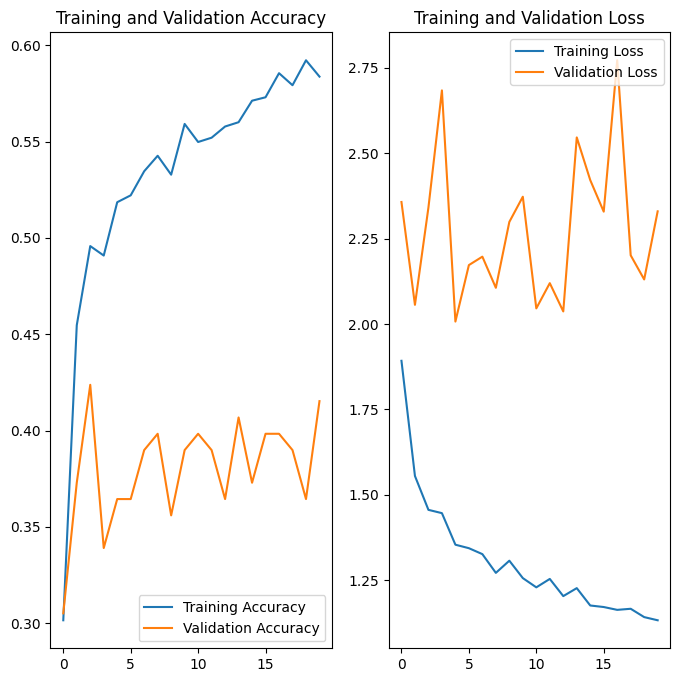

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

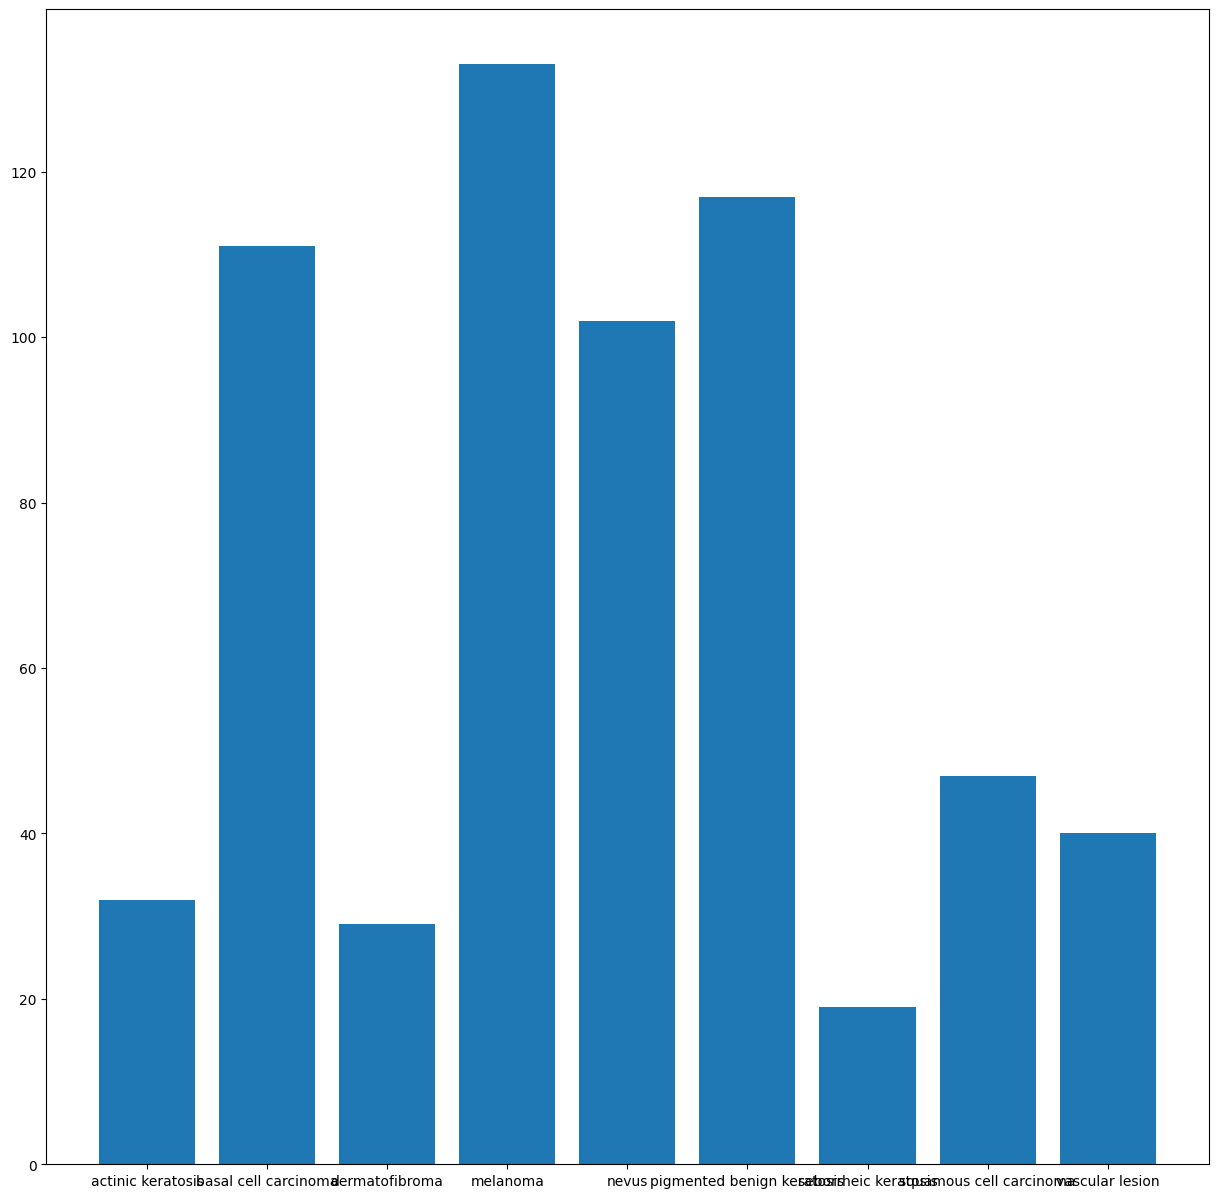

In [ ]:
## Your code goes here.
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C22302E2D40>: 100%|██████████| 500/500 [00:23<00:00, 21.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C223033F0A0>: 100%|██████████| 500/500 [00:23<00:00, 21.05 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2230232D10>: 100%|██████████| 500/500 [00:19<00:00, 26.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C2230373460>: 100%|██████████| 500/500 [01:23<00:00,  5.99 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C23336F9E10>: 100%|██████████| 500/500 [01:16<00:00,  6.53 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C22301C1C60>: 100%|██████████| 500/500 [00:18<00:00, 26.47 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C2230371990>: 100%|██████████| 500/500 [00:40<00:00, 12.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C233280D450>: 100%|██████████| 500/500 [00:19<00:00, 25.25 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2225D0F2B0>: 100%|██████████| 500/500 [00:18<00:00, 26.41 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_d8eaca26-04d5-40f2-95d5-e4e5355a4cd9.jpg',
 '/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_4e606d06-f1c7-4f05-842b-d59aefe79849.jpg',
 '/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_4e347c9d-5331-43c7-8dec-d6ac59da4577.jpg',
 '/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_3549fa6e-5a4b-447b-9e4a-cac76b299a47.jpg',
 '/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_0e2bbb25-6b33-425e-9d1f-61dbaf15dcca.jpg',
 '/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/ac

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = df2

In [ ]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
pigmented benign keratosis    500
seborrheic keratosis          500
nevus                         500
basal cell carcinoma          500
melanoma                      500
vascular lesion               500
dermatofibroma                500
squamous cell carcinoma       500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
input_shape = (180,180,3)

#### **Todo:** Create a training dataset

In [ ]:
"""import shutil
# Define the main directory
data_dir_train = "/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/"

# Function to move images from subdirectories to the parent class directory
def flatten_directory_structure(root_dir):
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            for subdir in os.listdir(class_path):
                subdir_path = os.path.join(class_path, subdir)
                if os.path.isdir(subdir_path):
                    for file_name in os.listdir(subdir_path):
                        file_path = os.path.join(subdir_path, file_name)
                        if os.path.isfile(file_path):
                            shutil.move(file_path, class_path)
                    os.rmdir(subdir_path)  # Remove the now-empty subdirectory

# Flatten the directory structure
flatten_directory_structure(data_dir_train)"""

'import shutil\n# Define the main directory\ndata_dir_train = "/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/"\n\n# Function to move images from subdirectories to the parent class directory\ndef flatten_directory_structure(root_dir):\n    for class_dir in os.listdir(root_dir):\n        class_path = os.path.join(root_dir, class_dir)\n        if os.path.isdir(class_path):\n            for subdir in os.listdir(class_path):\n                subdir_path = os.path.join(class_path, subdir)\n                if os.path.isdir(subdir_path):\n                    for file_name in os.listdir(subdir_path):\n                        file_path = os.path.join(subdir_path, file_name)\n                        if os.path.isfile(file_path):\n                            shutil.move(file_path, class_path)\n                    os.rmdir(subdir_path)  # Remove the now-empty subdirectory\n\n# Flatten the directory structure\nflatten_directory_structure(data_dir_train)'

In [ ]:
### Create a new folder called MERGEDTRAIN to hold both Train data and augmented data
import shutil
# Define the original and new directories
data_dir_train = "/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/"
flattened_data_dir = "/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/MergedTrain/"

# Create the new flattened directory if it doesn't exist
os.makedirs(flattened_data_dir, exist_ok=True)

# Function to flatten the directory structure into a new directory
def flatten_directory_structure(src_root_dir, dst_root_dir):
    for class_dir in os.listdir(src_root_dir):
        class_path = os.path.join(src_root_dir, class_dir)
        dst_class_path = os.path.join(dst_root_dir, class_dir)
        os.makedirs(dst_class_path, exist_ok=True)  # Create class subdirectory in the new directory

        if os.path.isdir(class_path):
            for root, _, files in os.walk(class_path):
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    if os.path.isfile(file_path):
                        shutil.copy(file_path, dst_class_path)  # Copy files to new directory

# Flatten the directory structure into the new directory
flatten_directory_structure(data_dir_train, flattened_data_dir)

In [ ]:


data_dir_train="/content/gdrive/MyDrive/CNN_SkinCancer_Assignment/CNN_assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model = Sequential()

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 20, 20, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Print some sample data from train_ds and val_ds
for batch in train_ds.take(1):
    images, labels = batch
    print("Train batch images shape:", images.shape)
    print("Train batch labels shape:", labels.shape)

for batch in val_ds.take(1):
    images, labels = batch
    print("Validation batch images shape:", images.shape)
    print("Validation batch labels shape:", labels.shape)

# Compile the model with eager execution for debugging
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Fit the model
#history = model.fit(train_ds, epochs=epochs, verbose=1, validation_data=val_ds, callbacks=[learning_rate_reduction])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 20, 20, 128)      

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
## Your code goes here, use 50 epochs.
#history = # your model fit code
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 249ms/step - loss: 9.7291 - accuracy: 0.1660 - val_loss: 2.1250 - val_accuracy: 0.1871
Epoch 2/30
169/169 [==============================] - 41s 238ms/step - loss: 2.2423 - accuracy: 0.1764 - val_loss: 2.1205 - val_accuracy: 0.1834
Epoch 3/30
169/169 [==============================] - 43s 247ms/step - loss: 2.1514 - accuracy: 0.1788 - val_loss: 2.1311 - val_accuracy: 0.1730
Epoch 4/30
169/169 [==============================] - 41s 237ms/step - loss: 2.1928 - accuracy: 0.1703 - val_loss: 2.0817 - val_accuracy: 0.2049
Epoch 5/30
169/169 [==============================] - 41s 238ms/step - loss: 2.1520 - accuracy: 0.1641 - val_loss: 2.1770 - val_accuracy: 0.1514
Epoch 6/30
169/169 [==============================] - 41s 234ms/step - loss: 2.0912 - accuracy: 0.1964 - val_loss: 2.0473 - val_accuracy: 0.2138
Epoch 7/30
169/169 [==============================] - 41s 238ms/step - loss: 2.0756 - accuracy: 0.2029 - val_loss: 2.1000 - val_ac

#### **Todo:**  Visualize the model results

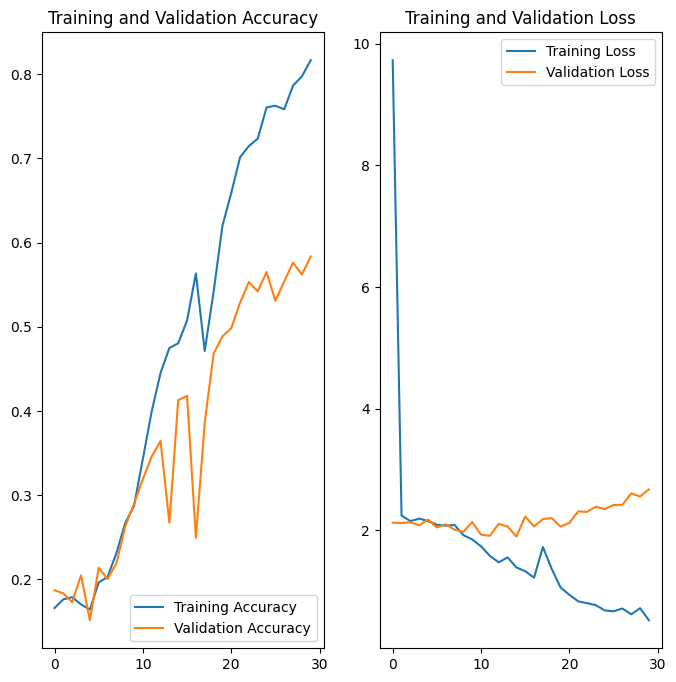

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
The training accuracy seems to be nearly ~80%.
The validation accuracy is nearly ~70%.
Though the model accuracy has improved, the class rebalance has helped treat the overfitting to some extent.
Much better models could be built or tried out using more epochs and more layers.